In [1]:
import numpy as np
import pandas as pd
import numba
from formatting_data import get_data_frame
from functions import draw_x_gametimes, draw_history, draw_log_history, printf

In [2]:
df, game_df = get_data_frame(10000) #game_df used for identifying game using game_id

In [3]:
user = df.loc[df.user_id == 0].sort_values(by='playtime', ascending=False).head(10)[['game_id', 'playtime']]
user_games = game_df.set_index(game_df.game_id).loc[user.game_id, 'game_name']
user_playtimes = user[['game_id', 'playtime']]

In [4]:
top10 = pd.merge(user_games, user_playtimes, on=['game_id'])

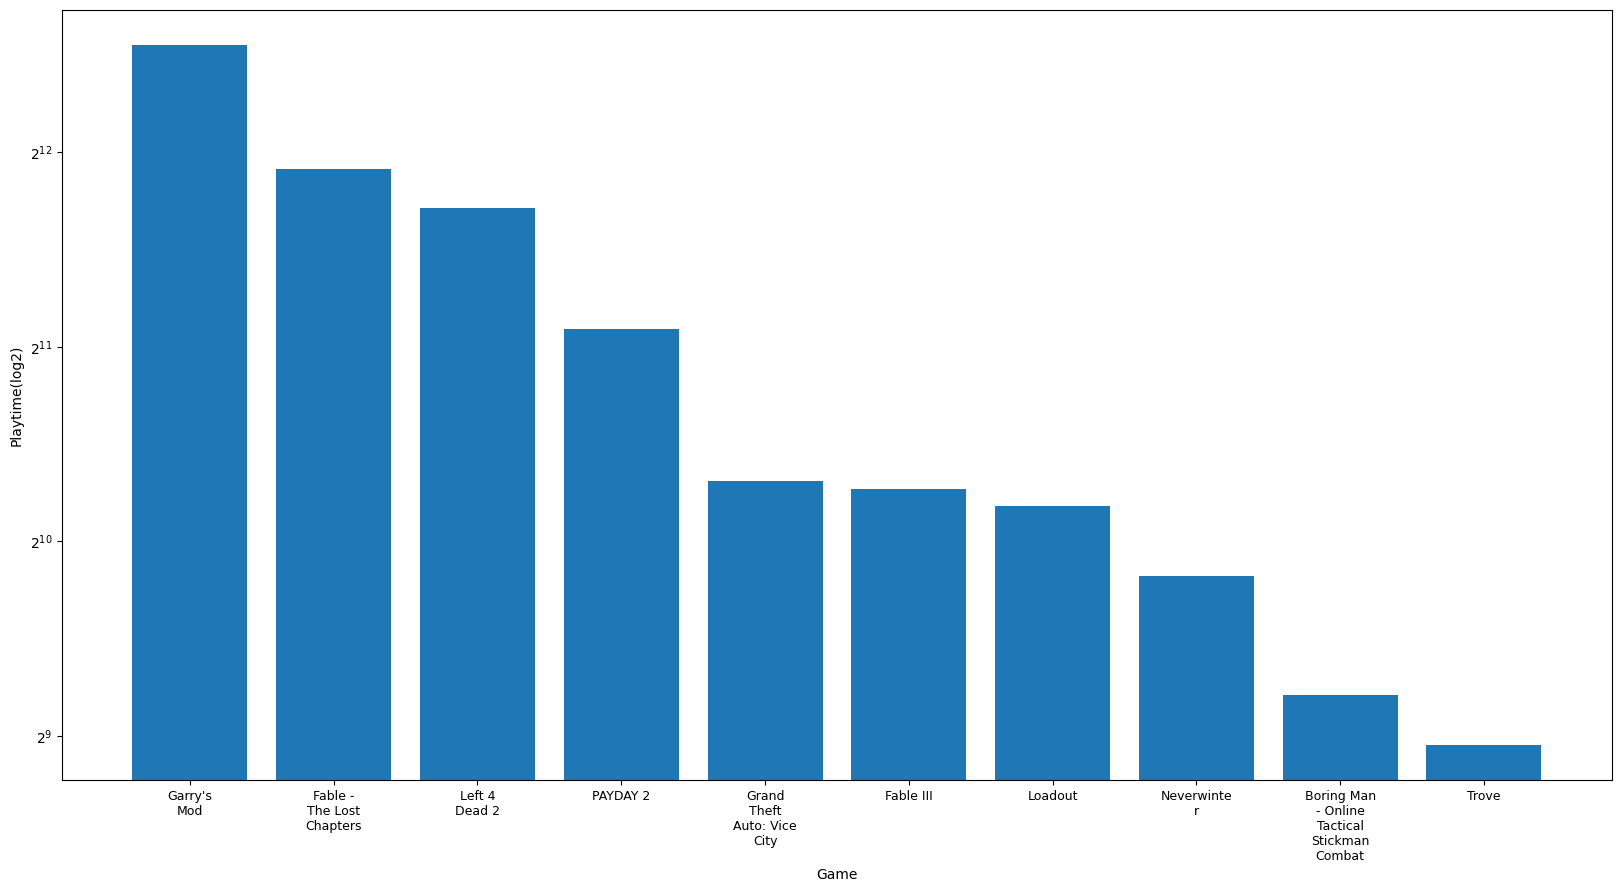

In [5]:
draw_x_gametimes(top10)

In [6]:
#creating utility matrix
utility_matrix = df.pivot_table(index=df.columns[0], columns=df.columns[1], values=df.columns[2], fill_value=0)
utility_matrix = utility_matrix.to_numpy(dtype=np.float32)

In [7]:
#R matrix for checking if the player has played the game
R = (utility_matrix != 0).astype(int)

In [8]:
num_features = 20
np.random.seed(9)

#initialising users and items features randomly
user_matrix = np.random.uniform(0,1,(utility_matrix.shape[0], num_features))
item_matrix = np.random.uniform(0,1,(utility_matrix.shape[1], num_features))
user_matrix = np.float32(user_matrix)
item_matrix = np.float32(item_matrix)

In [9]:
@numba.njit(nopython=True, parallel=True)
def cost(y, pred, R, chunk_size=500):
    cost = 0
    for i in range(0, y.shape[0], chunk_size):
        cost += np.sum(
                np.square(
                np.subtract(y[i:i+chunk_size], pred[i:i+chunk_size] * R[i:i+chunk_size])
            )
        )
    return cost/2

In [10]:
pred = user_matrix @ item_matrix.T
cost(utility_matrix, pred, R)

291905011712.0

In [80]:
#gradient descent
@numba.jit(nopython=True, parallel=True)
def gradient_descent(utilmat, theta, X, R, iterations, alpha, cost_func):
    history = []
    
    for i in range(iterations):
        pred = theta @ X.T
        error = (utilmat - pred * R)

        dj_dx = error.T @ theta
        dj_dx *= alpha

        dj_dtheta = error @ X
        dj_dtheta *= alpha

        theta += dj_dtheta
        X += dj_dx

        if i % (iterations // 10) == 0:
            J = cost_func(utilmat, pred, R)
            J = np.float32(J)
            history.append(J)
            printf(f'Iteration: {i}, cost: {J}')
        
    return theta, X, history

In [81]:
alpha = 0.0000001
iterations = 10

In [82]:
user_matrix, item_matrix, history = gradient_descent(utility_matrix, user_matrix, item_matrix, R, iterations, 0.0000001, cost)

Iteration: 0, cost: <object type:float32>
Iteration: 1, cost: <object type:float32>
Iteration: 2, cost: <object type:float32>
Iteration: 3, cost: <object type:float32>
Iteration: 4, cost: <object type:float32>
Iteration: 5, cost: <object type:float32>
Iteration: 6, cost: <object type:float32>
Iteration: 7, cost: <object type:float32>
Iteration: 8, cost: <object type:float32>
Iteration: 9, cost: <object type:float32>


In [ ]:
draw_history(range(0, iterations, iterations//10), history)

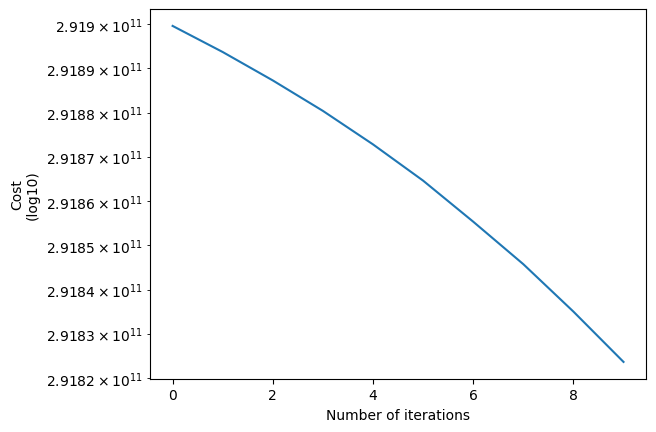

In [19]:
draw_log_history(range(0, iterations, iterations//10), history)

In [56]:
user = 100
top20 = np.sort(pred[user])[-20:]
top20i = np.where(np.isin(pred[user], top20))

In [57]:
time_df = pd.DataFrame({'game_id': np.array(top20i).flatten(), 'predicted_playtime': pred[user,top20i].flatten()})
top20_df = pd.merge(game_df.iloc[top20i], time_df, on=['game_id'])
top20_df = top20_df.sort_values(ascending=False, by=['predicted_playtime'])
top20_df = top20_df.reset_index(drop=True)

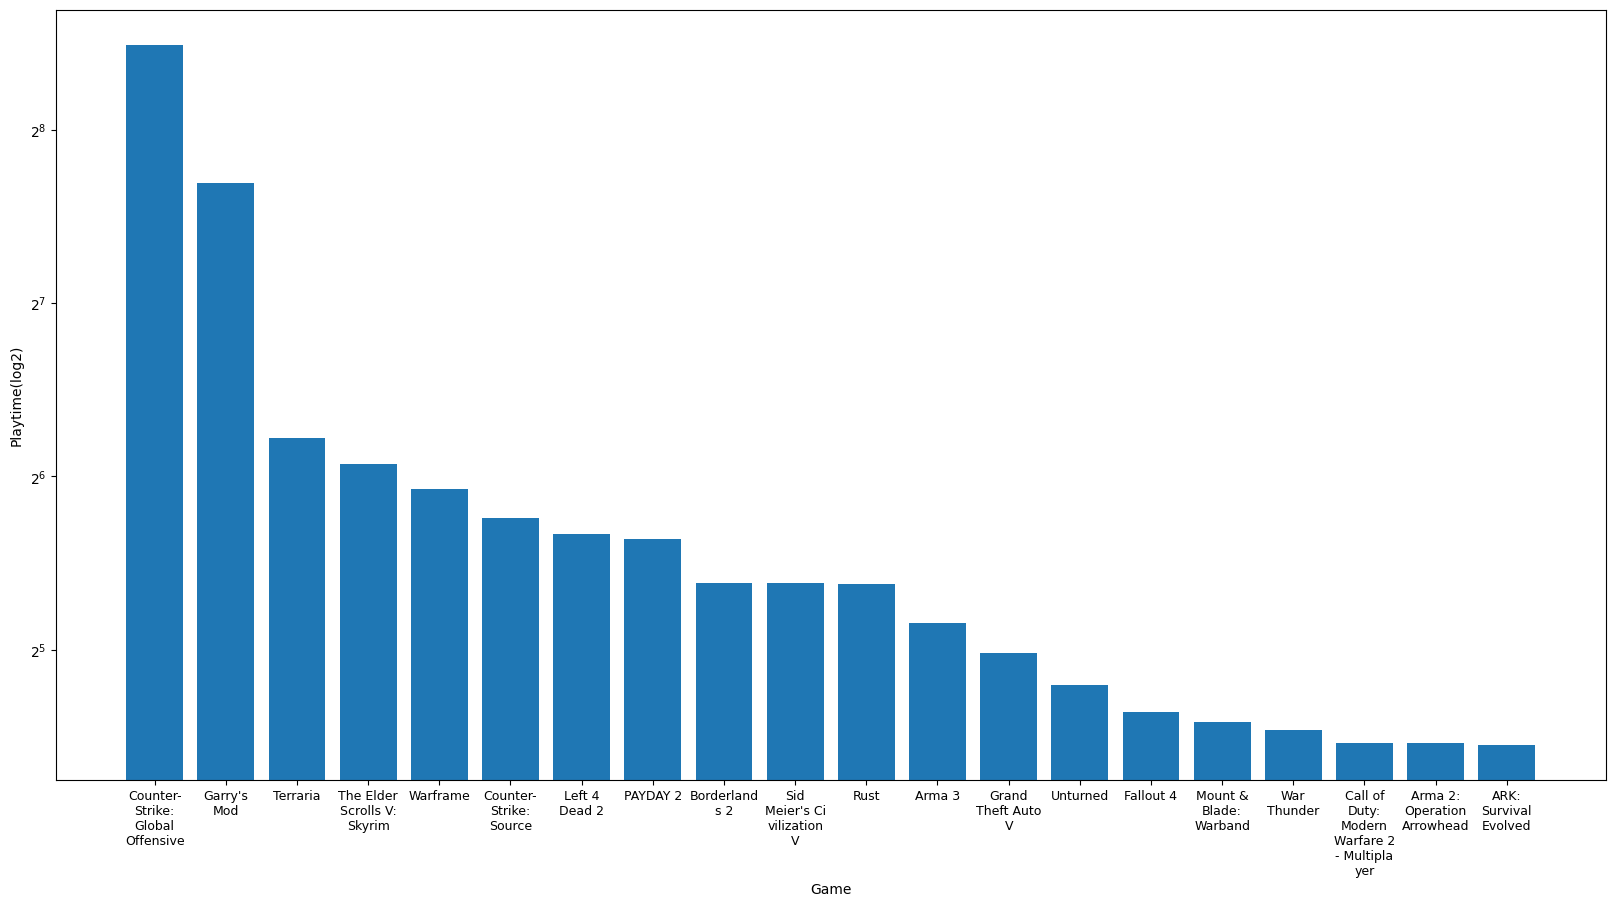

In [58]:
draw_x_gametimes(top20_df)

In [59]:
np.savetxt('model_matrices/user.txt', user_matrix)
np.savetxt('model_matrices/item.txt', item_matrix)